In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import squidpy as sq
import sccellfie
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import glasbey
import h5py
import math

import textwrap

from pathlib import Path

In [3]:
base_dir = Path().resolve()
parent_dir = base_dir.parent
parent_dir

PosixPath('/home/sadegh/projects/nanostring-cosmx-spatial-omics-modeling')

## Load Datasets

In [ ]:
# with h5py.File("merged_TMA_processed.h5ad", "r+") as f:
#     if "uns" in f and "log1p" in f["uns"] and "base" in f["uns/log1p"]:
#         del f["uns/log1p/base"]

In [5]:
# Load the dataset
adata = sc.read(filename=parent_dir / 'data/h5ad/merged_TMA_processed_compatible_n_gene_200.h5ad')
adata

AnnData object with n_obs × n_vars = 242061 × 1011
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'leiden'
    var: 'gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
adata.var_names = adata.var["gene"].astype(str)
adata.var_names_make_unique()

In [9]:
subject_treatment_df = pd.DataFrame(adata.obs[["Subject_ID","Treatment_Status"]])
subject_treatment_df

Subject_ID Treatment_Status
58_1_TMA1_minimal         89397          Treated
63_1_TMA1_minimal         89397          Treated
87_1_TMA1_minimal         89397          Treated
191_1_TMA1_minimal        89397          Treated
193_1_TMA1_minimal        89397          Treated
...                         ...              ...
398_417_TMA4_minimal   1228762B        Untreated
405_417_TMA4_minimal   1228762B        Untreated
411_417_TMA4_minimal   1228762B        Untreated
418_417_TMA4_minimal   1228762B        Untreated
586_417_TMA4_minimal   1228762B        Untreated

[242061 rows x 2 columns]

## Review the Subject id vs Treatment status

In [10]:
adata.obs["Treated"]   = (adata.obs["Treatment_Status"].astype(str) == "Treated").astype(int)
adata.obs["Untreated"] = (adata.obs["Treatment_Status"].astype(str) == "Untreated").astype(int)


In [11]:
# sc.pl.dotplot(
#     adata,
#     var_names=["Treated","Untreated"],  
#     groupby="Subject_ID",
#     mean_only_expressed=False,
#     expression_cutoff=0,
#     swap_axes=False,
#     vmin=0, vmax=1,
#     colorbar_title="Fraction of cells"
# )


## Apply scCellFie Pipeline

In [12]:
results = sccellfie.run_sccellfie_pipeline(adata,
                                           organism='human',
                                           sccellfie_data_folder=None,
                                           n_counts_col='nCount_Nanostring',
                                           process_by_group=False,
                                           groupby=None,
                                           neighbors_key='neighbors',
                                           n_neighbors=10,
                                           batch_key='sample',
                                           threshold_key='sccellfie_threshold',
                                           smooth_cells=True,
                                           alpha=0.33,
                                           chunk_size=5000,
                                           disable_pbar=False,
                                           save_folder=None,
                                           save_filename=None
                                          )


==== scCellFie Pipeline: Initializing ====
Loading scCellFie database for organism: human

==== scCellFie Pipeline: Processing entire dataset ====

---- scCellFie Step: Preprocessing data ----

---- scCellFie Step: Preparing inputs ----
Gene names corrected to match database: 22
Shape of new adata object: (242061, 26)
Number of GPRs: 81
Shape of tasks by genes: (107, 26)
Shape of reactions by genes: (81, 26)
Shape of tasks by reactions: (107, 81)

---- scCellFie Step: Smoothing gene expression ----


Smoothing Expression: 100%|██████████| 49/49 [00:03<00:00, 16.31it/s]



---- scCellFie Step: Computing gene scores ----

---- scCellFie Step: Computing reaction activity ----


Cell Rxn Activities: 100%|██████████| 242061/242061 [03:33<00:00, 1136.31it/s]



---- scCellFie Step: Computing metabolic task activity ----
Removed 0 metabolic tasks with zeros across all cells.

==== scCellFie Pipeline: Processing completed successfully ====


## scCellFie Result Data Understanding

In [13]:
results

{'adata': AnnData object with n_obs × n_vars = 242061 × 26
     obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'leiden', 'Treated', 'Untreated'
     var: 'gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 'std'
     uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap', 'normalization'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     layers: 'counts', 's

In [15]:
metabolic_data = results['adata'].metabolic_tasks
metabolic_data

AnnData object with n_obs × n_vars = 242061 × 107
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'leiden', 'Treated', 'Untreated'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap', 'normalization'
    obsm: 'X_pca', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [16]:
reaction_data = results['adata'].reactions
reaction_data

AnnData object with n_obs × n_vars = 242061 × 81
    obs: 'nCount_Nanostring', 'nFeature_Nanostring', 'cell_ID', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CD68', 'Max.CD68', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'Mean.CD45', 'Max.CD45', 'Mean.DAPI', 'Max.DAPI', 'id', 'TMA', 'Subject_ID', 'Treatment_Status', 'Run_Tissue_name', 'log10totalcounts', 'cell_type', 'tissue', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'leiden', 'Treated', 'Untreated'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'umap', 'normalization', 'Rxn-Max-Genes'
    obsm: 'X_pca', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

## Save Gene, Reactions and Metabolic Tasks as CSV

In [21]:
# results['adata'].reactions.X or results['adata'].metabolic_tasks.X
df = pd.DataFrame(
    results['adata'].X,
    index=results['adata'].obs.index,
    columns=results['adata'].var.index
    )
df

ACACB      ARF1      ARG1    ATP5F1E     B3GNT7  \
58_1_TMA1_minimal     -5.138619  8.119103  2.836610   2.492469  -4.380625   
63_1_TMA1_minimal     -3.541723  4.561964 -2.779527  -2.243974   1.560384   
87_1_TMA1_minimal     18.136440  4.033157 -2.392830   0.948675  22.993375   
191_1_TMA1_minimal    15.395354  8.423884 -2.329424   0.719245  24.102954   
193_1_TMA1_minimal    -2.160676  8.438063 -2.875661   5.004335  26.868916   
...                         ...       ...       ...        ...        ...   
398_417_TMA4_minimal  -3.426391 -0.393934  0.616400 -10.603558  18.148791   
405_417_TMA4_minimal  -3.898579  1.879530 -2.270151  -1.594427   2.706135   
411_417_TMA4_minimal  -3.594412  8.188699 -2.657738  -8.688623  -0.195468   
418_417_TMA4_minimal  -4.327501  4.254058 -0.780513   0.154987   1.407598   
586_417_TMA4_minimal  21.692363  4.310915 -0.783608 -32.813314  31.378400   

                          CALM1     CYP1B1     CYP2U1        DDC       ENO1  \
58_1_TMA1_minimal     20.516544  -4.738219  -4.377451  -6.284169   3.933897   
63_1_TMA1_minimal      6.831265  -4.168286  29.780418  -7.596944   7.148608   
87_1_TMA1_minimal     -8.208050  -3.588381  -3.315162  15.884180  -1.320643   
191_1_TMA1_minimal     9.592794  -3.493294  -0.936705  -3.568302   2.728620   
193_1_TMA1_minimal     7.875155  -2.479085   0.351055  -5.432313   6.843135   
...                         ...        ...        ...        ...        ...   
398_417_TMA4_minimal  -9.310585  -2.381214   1.025038  -4.821395  -4.989624   
405_417_TMA4_minimal   9.019791  -2.021793  -3.145194  -4.202376 -16.241138   
411_417_TMA4_minimal  10.117386  -3.985646  -3.682179  -6.270500 -17.995439   
418_417_TMA4_minimal   2.391194  -1.430165  -0.471523  -4.747896  -1.361154   
586_417_TMA4_minimal   6.488350  25.279477  -3.513861  -5.938782 -19.979024   

                      ...    HSP90B1       IDO1       KYNU       LDHA  \
58_1_TMA1_minimal     ...  14.687612  -4.471430  -5.358273   6.147044   
63_1_TMA1_minimal     ...  -1.012455  19.031523  -2.789910   1.174960   
87_1_TMA1_minimal     ... -13.579868  -4.490324  -4.057965   5.036203   
191_1_TMA1_minimal    ...   4.421024  -4.371337  -3.950435   9.015220   
193_1_TMA1_minimal    ... -16.605717  -3.960222  -3.554977   9.167266   
...                   ...        ...        ...        ...        ...   
398_417_TMA4_minimal  ...  -1.654827  13.098676  -1.610100  -1.166847   
405_417_TMA4_minimal  ... -14.130730  -4.260107  -3.849914   6.176809   
411_417_TMA4_minimal  ... -17.189737  -2.367172  -3.137285  -0.904928   
418_417_TMA4_minimal  ... -12.937306  -2.884938  25.163876  -3.400420   
586_417_TMA4_minimal  ...  -0.276542  -2.434894  -4.301185 -22.090102   

                          PTGS1     PTGS2     SEC61G    ST6GAL1       TP53  \
58_1_TMA1_minimal     -4.321997 -3.065980 -15.751696  -6.612187  12.668953   
63_1_TMA1_minimal     -3.802129 -3.929844 -14.178326  -5.273250 -10.162521   
87_1_TMA1_minimal     25.181430 -0.897421  -8.557185  11.860245  -6.510208   
191_1_TMA1_minimal    -3.186431 -1.705948   5.554974  12.468108   9.490307   
193_1_TMA1_minimal    -3.933632 -4.065764 -12.952505  -6.067353  -9.663771   
...                         ...       ...        ...        ...        ...   
398_417_TMA4_minimal  -2.711357 -2.802432  -9.983576  -5.560806  -6.968706   
405_417_TMA4_minimal  -3.105351 -1.639232  -9.437174  -6.368860  -9.043190   
411_417_TMA4_minimal  -1.798173 -3.757652 -10.584222  -7.456227  -9.948525   
418_417_TMA4_minimal  -2.873141 -2.969651   6.210321  -5.405629   4.599068   
586_417_TMA4_minimal  -3.469347 -3.585884   2.581377  -7.115391  -9.271838   

                          TYMS  
58_1_TMA1_minimal    -9.150918  
63_1_TMA1_minimal    -6.501061  
87_1_TMA1_minimal     5.960089  
191_1_TMA1_minimal   -5.532738  
193_1_TMA1_minimal    9.325951  
...                        ...  
398_417_TMA4_minimal -6.486689  
405_417_TMA4_minimal -7.293438  
411_417_TMA4_minimal -8.760313  
418_417_

In [ ]:
# df.to_csv('scCellFie_genes_with_name.csv')

In [ ]:
# Save adata objects containing single-cell/spatial predictions in H5AD format
sccellfie.io.save_adata(adata=results['adata'],
                        output_directory='output/',
                        filename='sccellfie_results'
                        )

## Visualization on scCellFie Data

In [12]:
gp = 'Subject_ID'

### Cell group level for the Metabolic Task Visualizer

In [ ]:
# Summarize results in a cell-group level for the Metabolic Task Visualizer
report = sccellfie.reports.generate_report_from_adata(results['adata'].metabolic_tasks,
                                                      group_by=gp,
                                                      feature_name='metabolic_task'
                                                      )

In [ ]:
# Export files to a specific folder.
sccellfie.io.save_result_summary(results_dict=report, output_directory='report/')

In [13]:
metabolic_tasks = ['ATP generation from glucose (hypoxic conditions) - glycolysis', 
                   'ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle',
                   'Gluconeogenesis from Lactate',
                   'Glutaminolysis (glutamine to lactate)',
                   'Glucose to lactate conversion'
                  ]
# metabolic_tasks = results['adata'].metabolic_tasks.var.index.tolist()
metabolic_tasks

['ATP generation from glucose (hypoxic conditions) - glycolysis',
 'ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle',
 'Gluconeogenesis from Lactate',
 'Glutaminolysis (glutamine to lactate)',
 'Glucose to lactate conversion']

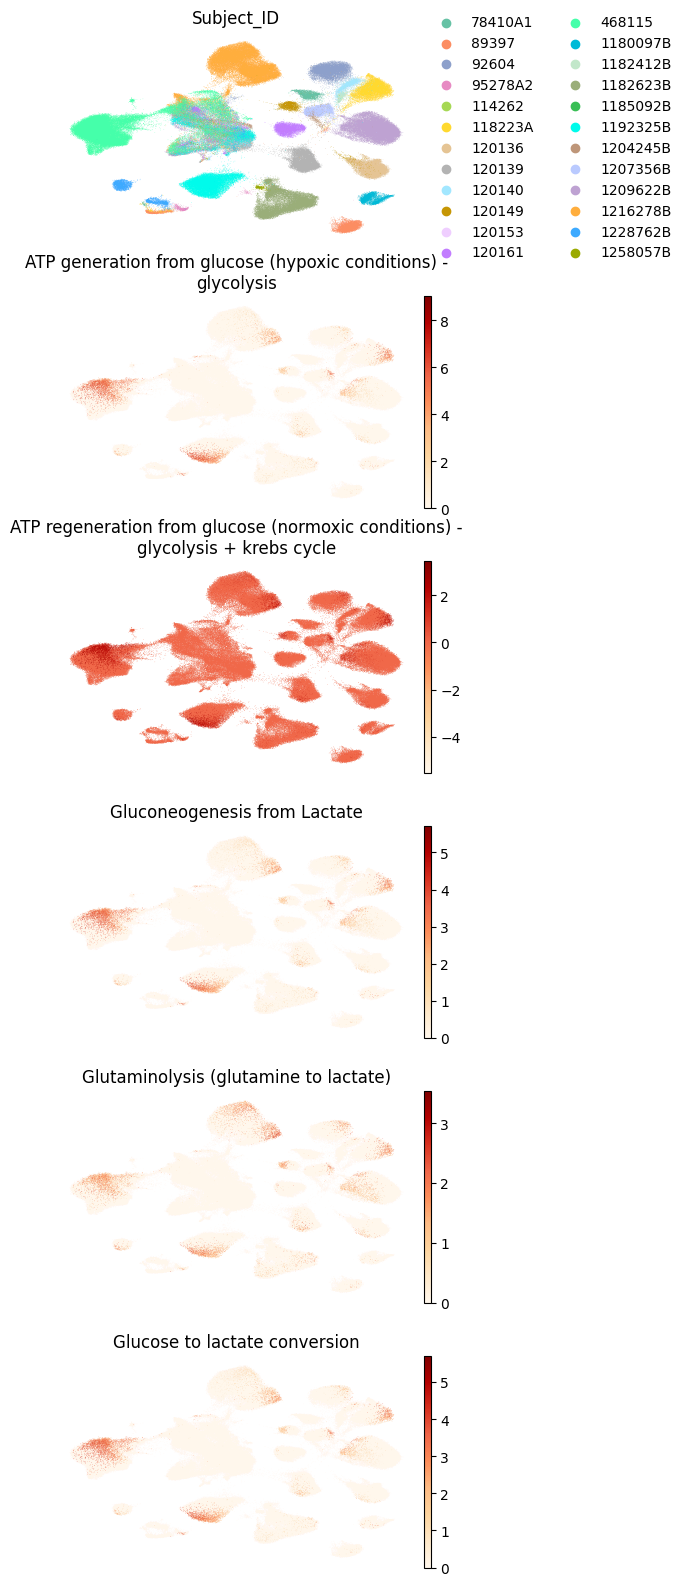

In [14]:
palette = glasbey.extend_palette('Set2', palette_size=max([10, results['adata'].metabolic_tasks.obs[gp].unique().shape[0]]))

plt.rcParams['figure.figsize'] = (3,3)
plt.rcParams['font.size'] = 10

sc.pl.embedding(results['adata'].metabolic_tasks,
                color=[gp] + metabolic_tasks,
                ncols=1,
                palette=palette,
                frameon=False,
                basis='X_umap',
                wspace=0.7,
                title=["\n".join(textwrap.wrap(t, width=60)) for t in [gp] + metabolic_tasks],
                cmap='OrRd'
               )

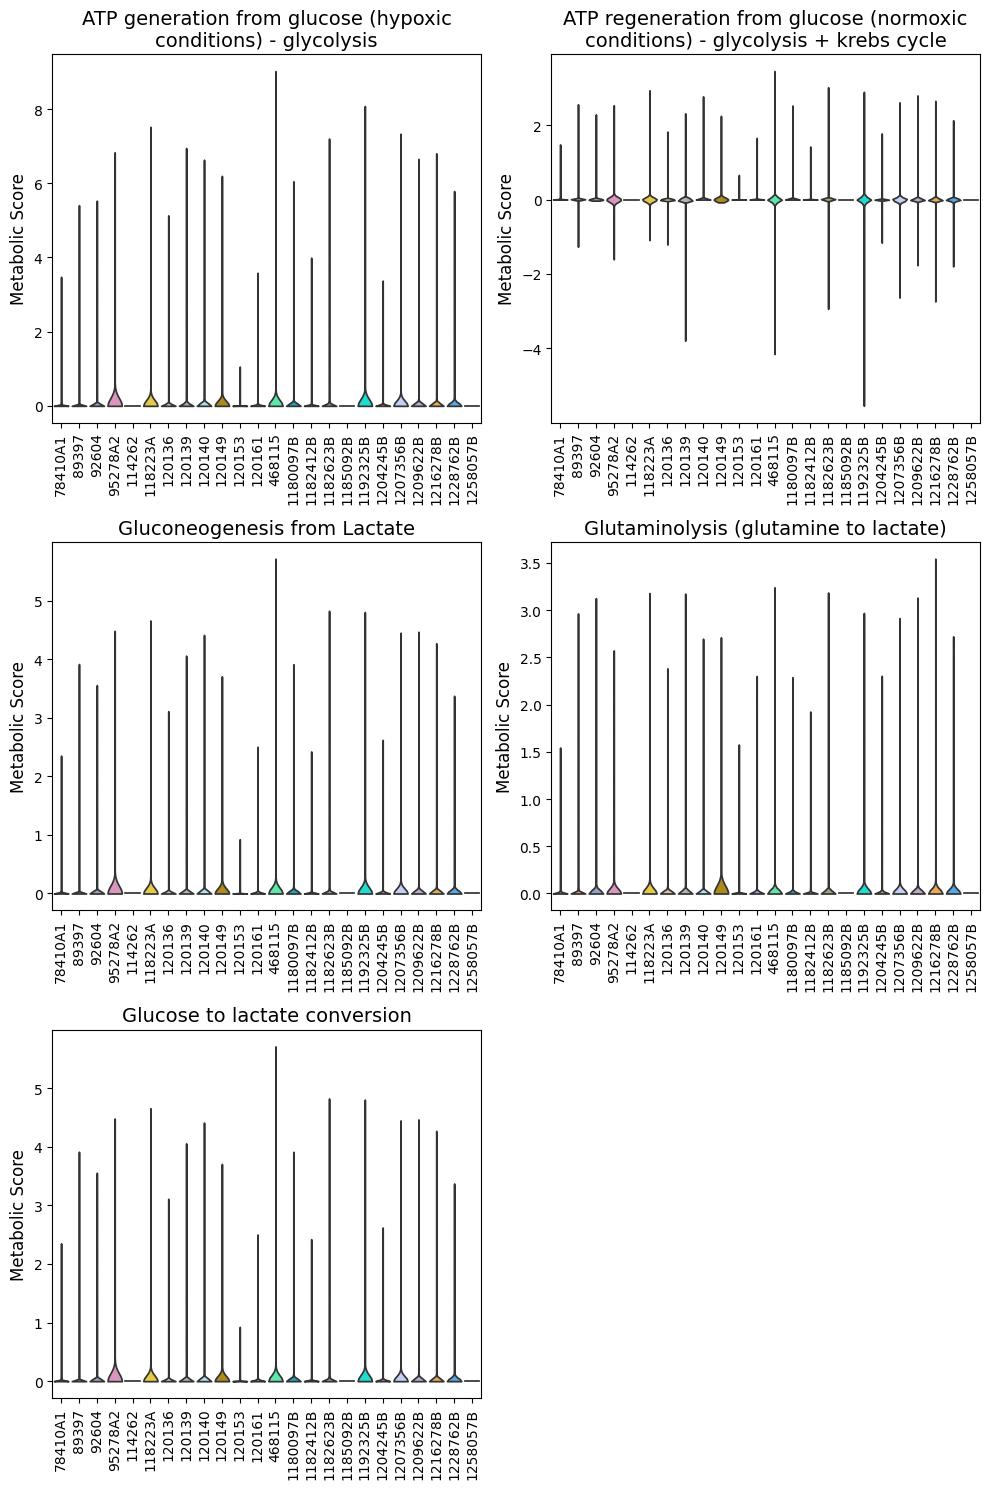

In [15]:
# Violin Plot
fig, axes = sccellfie.plotting.create_multi_violin_plots(results['adata'].metabolic_tasks,
                                                         features=metabolic_tasks,
                                                         groupby=gp,
                                                         stripplot=False,
                                                         n_cols=2,
                                                         ylabel='Metabolic Score'
                                                        )

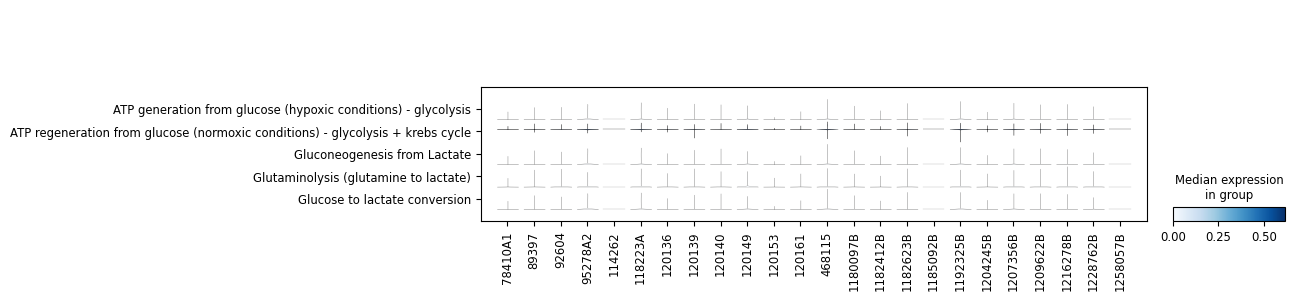

In [16]:
ax = sc.pl.stacked_violin(results['adata'].metabolic_tasks, metabolic_tasks, groupby=gp, swap_axes=True, dendrogram=False, standard_scale='var')

### Dot Plot

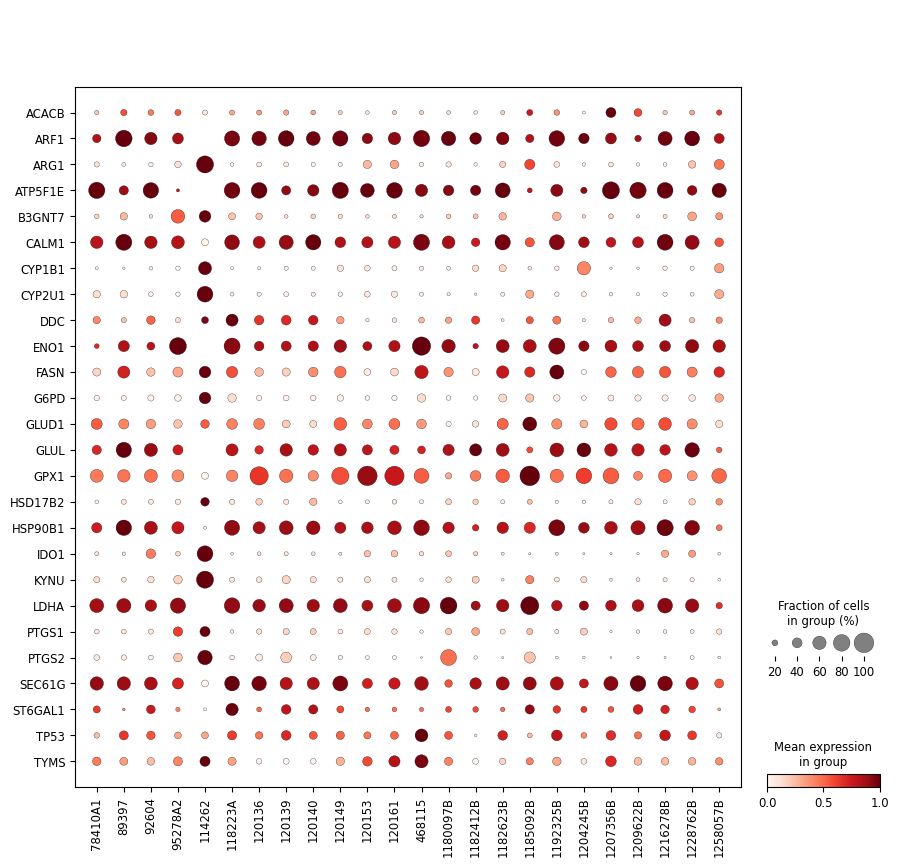

In [17]:
# Genes
sc.pl.dotplot(results['adata'], var_names=results['adata'].var.index, groupby=gp, swap_axes=True, standard_scale='var')

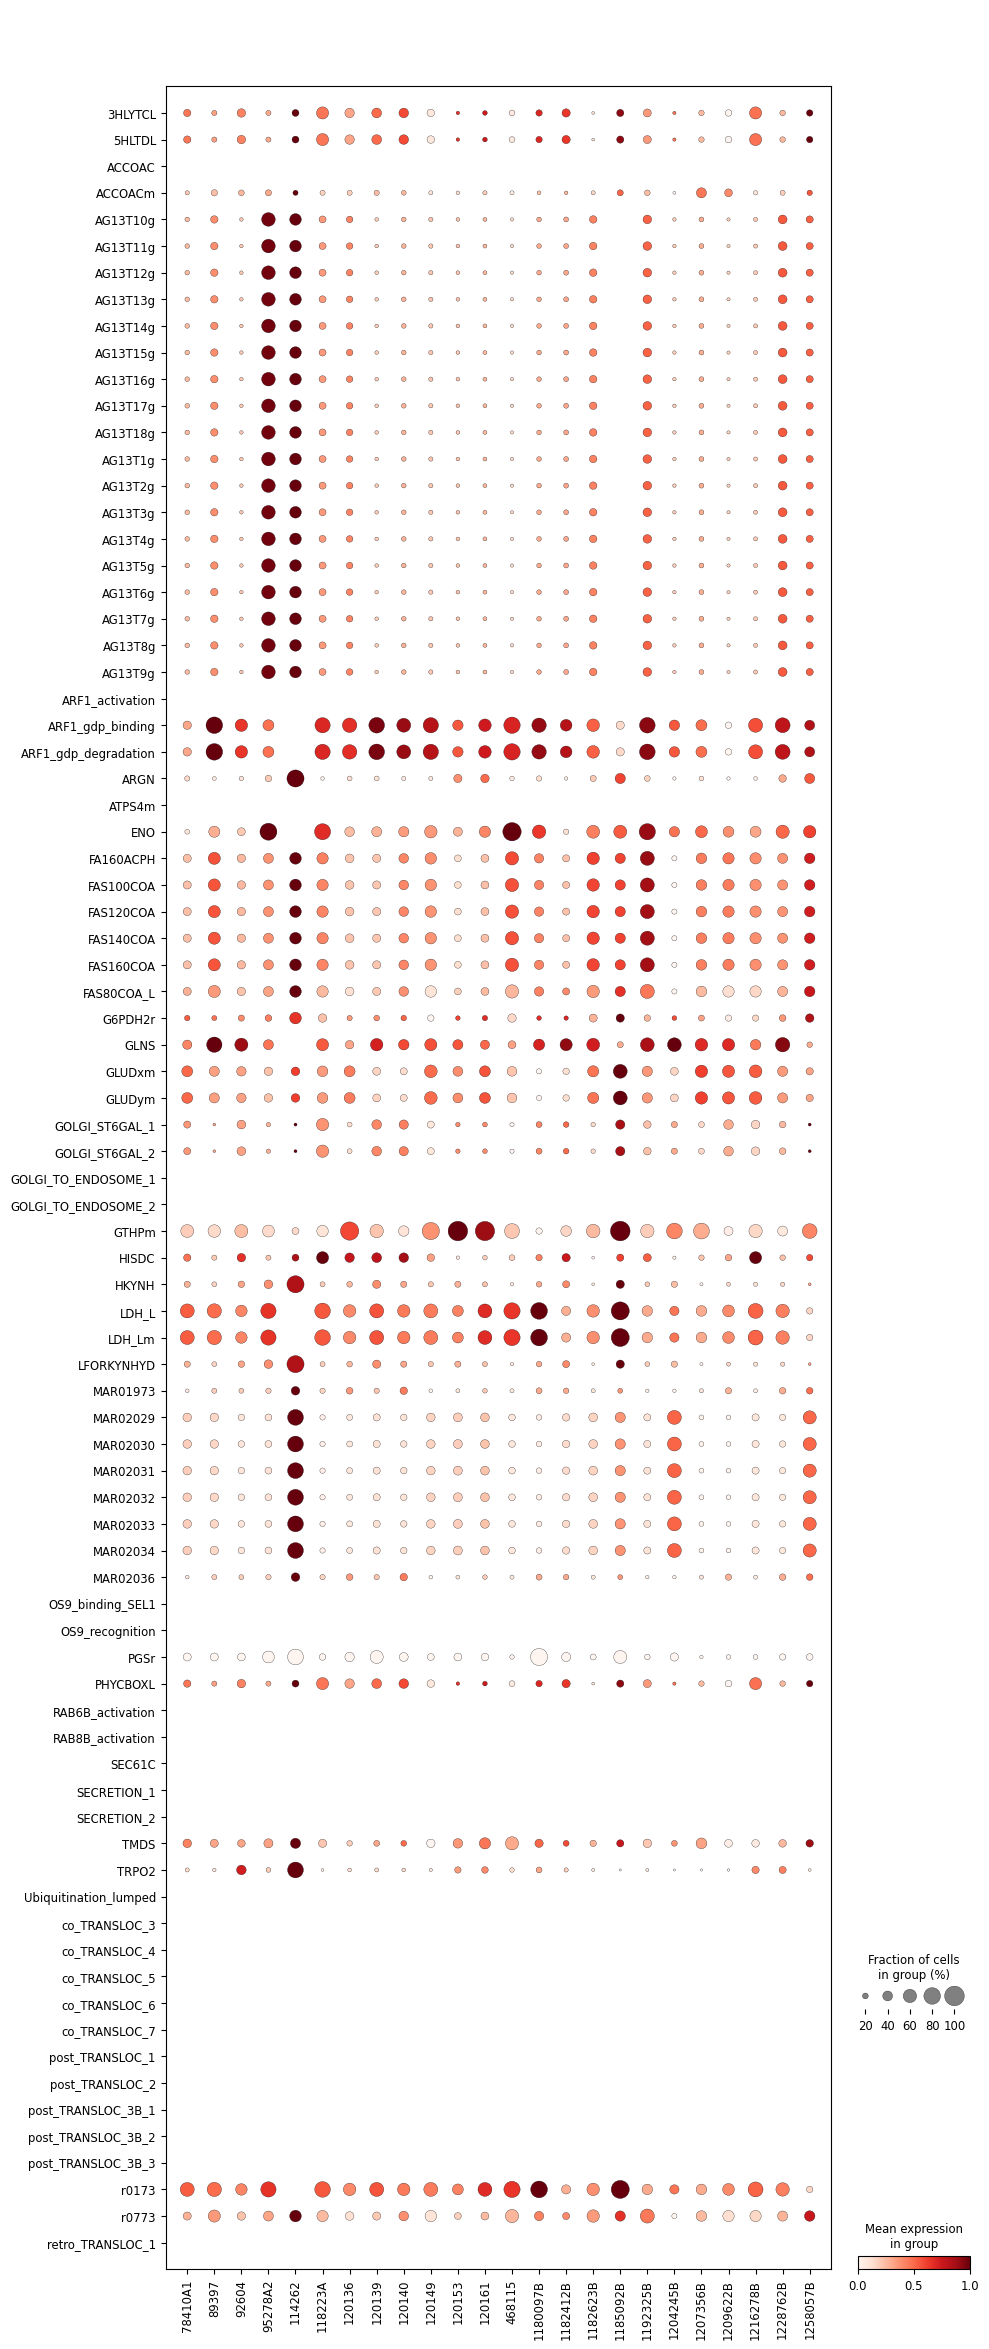

In [21]:
# Reactions
sc.pl.dotplot(reaction_data, var_names=results['adata'].reactions.var.index, groupby=gp, swap_axes=True, standard_scale='var')

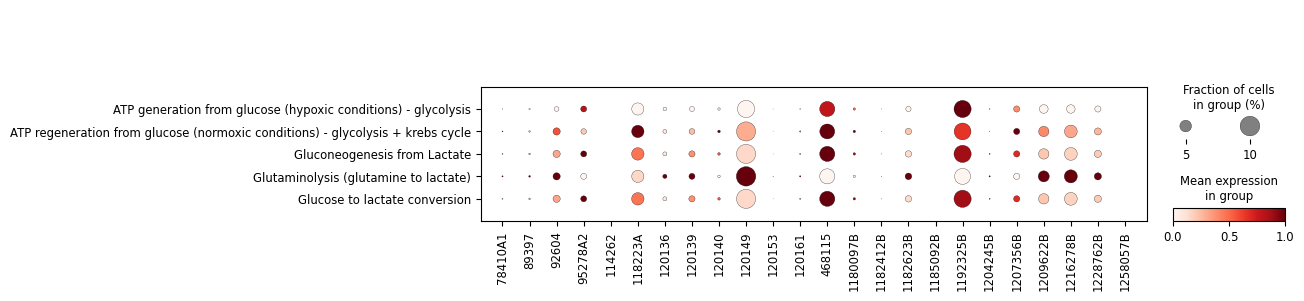

In [22]:
# Metabolic Tasks
sc.pl.dotplot(metabolic_data, var_names=metabolic_tasks, groupby=gp, swap_axes=True, standard_scale='var')

### Heat Map 

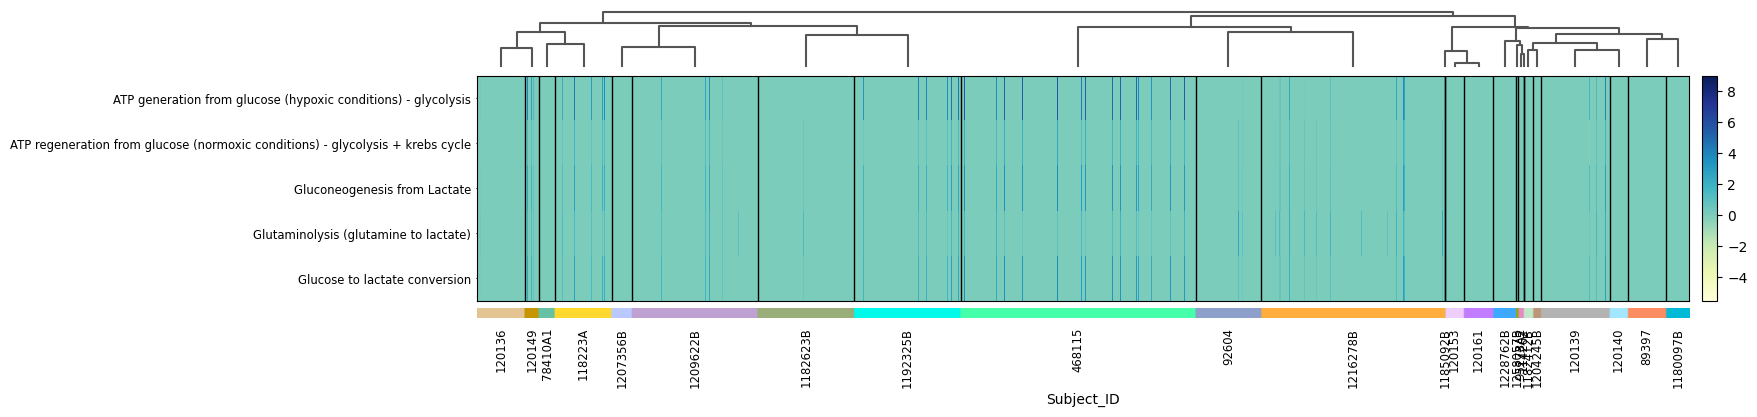

In [23]:
ax = sc.pl.heatmap(metabolic_data, var_names=metabolic_tasks, groupby=gp, cmap="YlGnBu", swap_axes=True, dendrogram=True,
                   figsize=(16, 4)
                  )

### Aggregation 

In [49]:
# number of non zero metaboli tasks data
count = np.count_nonzero(metabolic_data.X)
count

974267

In [51]:
gp

'Subject_ID'

In [52]:
agg = sccellfie.expression.aggregation.agg_expression_cells(metabolic_data, groupby=gp, agg_func='mean')

In [53]:
(agg != 0).sum().sum()


np.int64(2189)

In [54]:
input_df = sccellfie.preprocessing.matrix_utils.min_max_normalization(agg.T, axis=1)

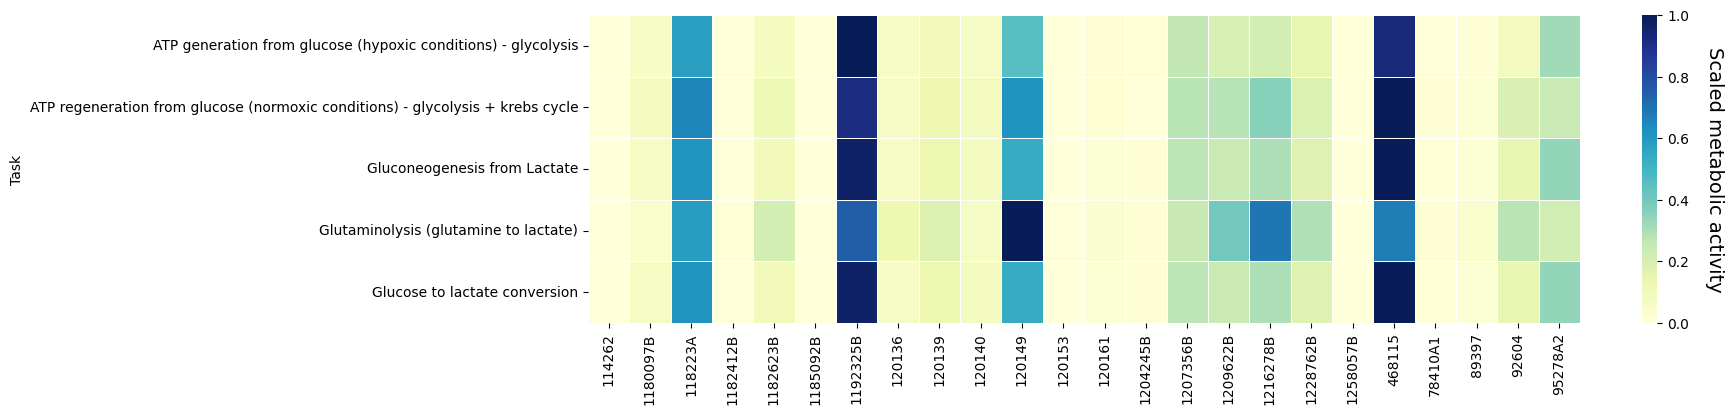

In [55]:
plt.figure(figsize=(16, 4))
g = sns.heatmap(input_df.loc[metabolic_tasks,:], cmap='YlGnBu', linewidths=0.5, xticklabels=1, yticklabels=1)

cbar = g.collections[0].colorbar
cbar.set_label('Scaled metabolic activity', size=14, rotation=270, labelpad=25)  # Change colorbar label size and rotation

# Uncomment code below to save figure
# plt.savefig('./figures/Heatmap-Seaborn.pdf', dpi=300, bbox_inches='tight')

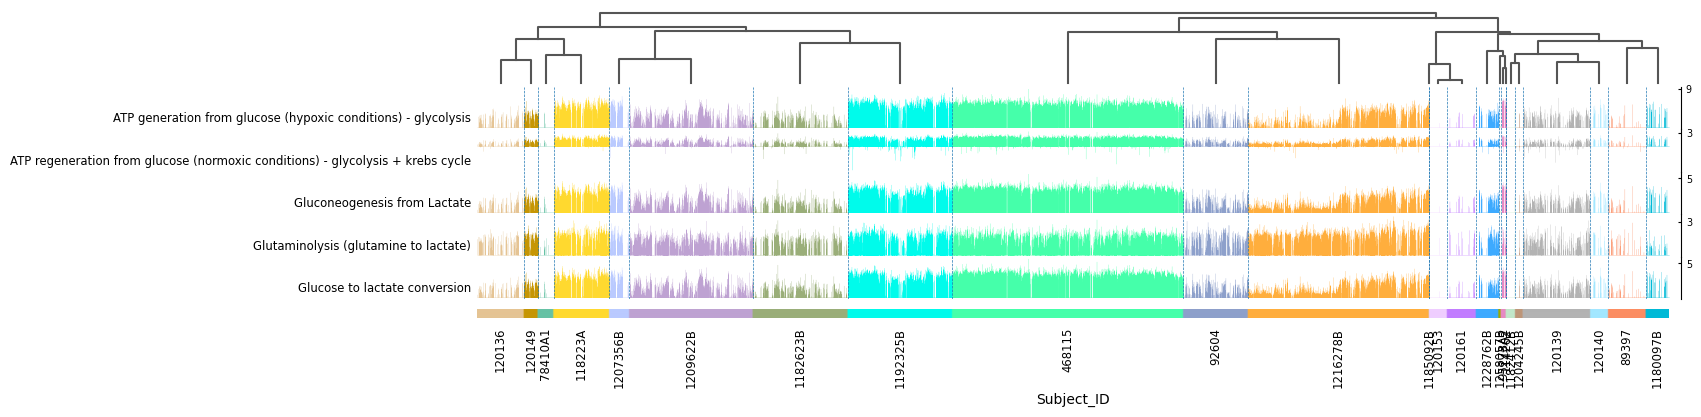

In [27]:
ax = sc.pl.tracksplot(metabolic_data, var_names=metabolic_tasks, groupby=gp, dendrogram=True, figsize=(16, 4))

### Radial Plot

In [57]:
df_melted = pd.melt(input_df.reset_index(), id_vars='Task', var_name='cell_type', value_name='scaled_trimean')
df_melted = df_melted.rename(columns={'Task': 'metabolic_task'})
df_melted.head()

metabolic_task cell_type  scaled_trimean
0                   (R)-3-Hydroxybutanoate synthesis    114262             0.0
1  ATP generation from glucose (hypoxic condition...    114262             0.0
2  ATP regeneration from glucose (normoxic condit...    114262             0.0
3                             Acetoacetate synthesis    114262             0.0
4                                Alanine degradation    114262             0.0

In [58]:
ct = df_melted.cell_type.unique()[0:4]
ct

array(['114262', '1180097B', '118223A', '1182412B'], dtype=object)

In [59]:
df_melted

metabolic_task cell_type  \
0                      (R)-3-Hydroxybutanoate synthesis    114262   
1     ATP generation from glucose (hypoxic condition...    114262   
2     ATP regeneration from glucose (normoxic condit...    114262   
3                                Acetoacetate synthesis    114262   
4                                   Alanine degradation    114262   
...                                                 ...       ...   
2563                           beta-Alanine degradation   95278A2   
2564                             beta-Alanine synthesis   95278A2   
2565                      cis-vaccenic acid degradation   95278A2   
2566                        cis-vaccenic acid synthesis   95278A2   
2567                       gamma-Linolenate degradation   95278A2   

      scaled_trimean  
0           0.000000  
1           0.000000  
2           0.000000  
3           0.000000  
4           0.000000  
...              ...  
2563        0.302396  
2564        0.317722  
2565        0.224109  
2566        0.305142  
2567        0.224109  

[2568 rows x 3 columns]

In [60]:
subset = df_melted[df_melted['cell_type'] == str(ct[i])]
print(subset.head())
print(subset.isna().sum())

                                        metabolic_task cell_type  \
321                   (R)-3-Hydroxybutanoate synthesis  1182412B   
322  ATP generation from glucose (hypoxic condition...  1182412B   
323  ATP regeneration from glucose (normoxic condit...  1182412B   
324                             Acetoacetate synthesis  1182412B   
325                                Alanine degradation  1182412B   

     scaled_trimean  
321        0.005626  
322        0.005626  
323        0.006123  
324        0.005626  
325        0.008734  
metabolic_task    0
cell_type         0
scaled_trimean    0
dtype: int64


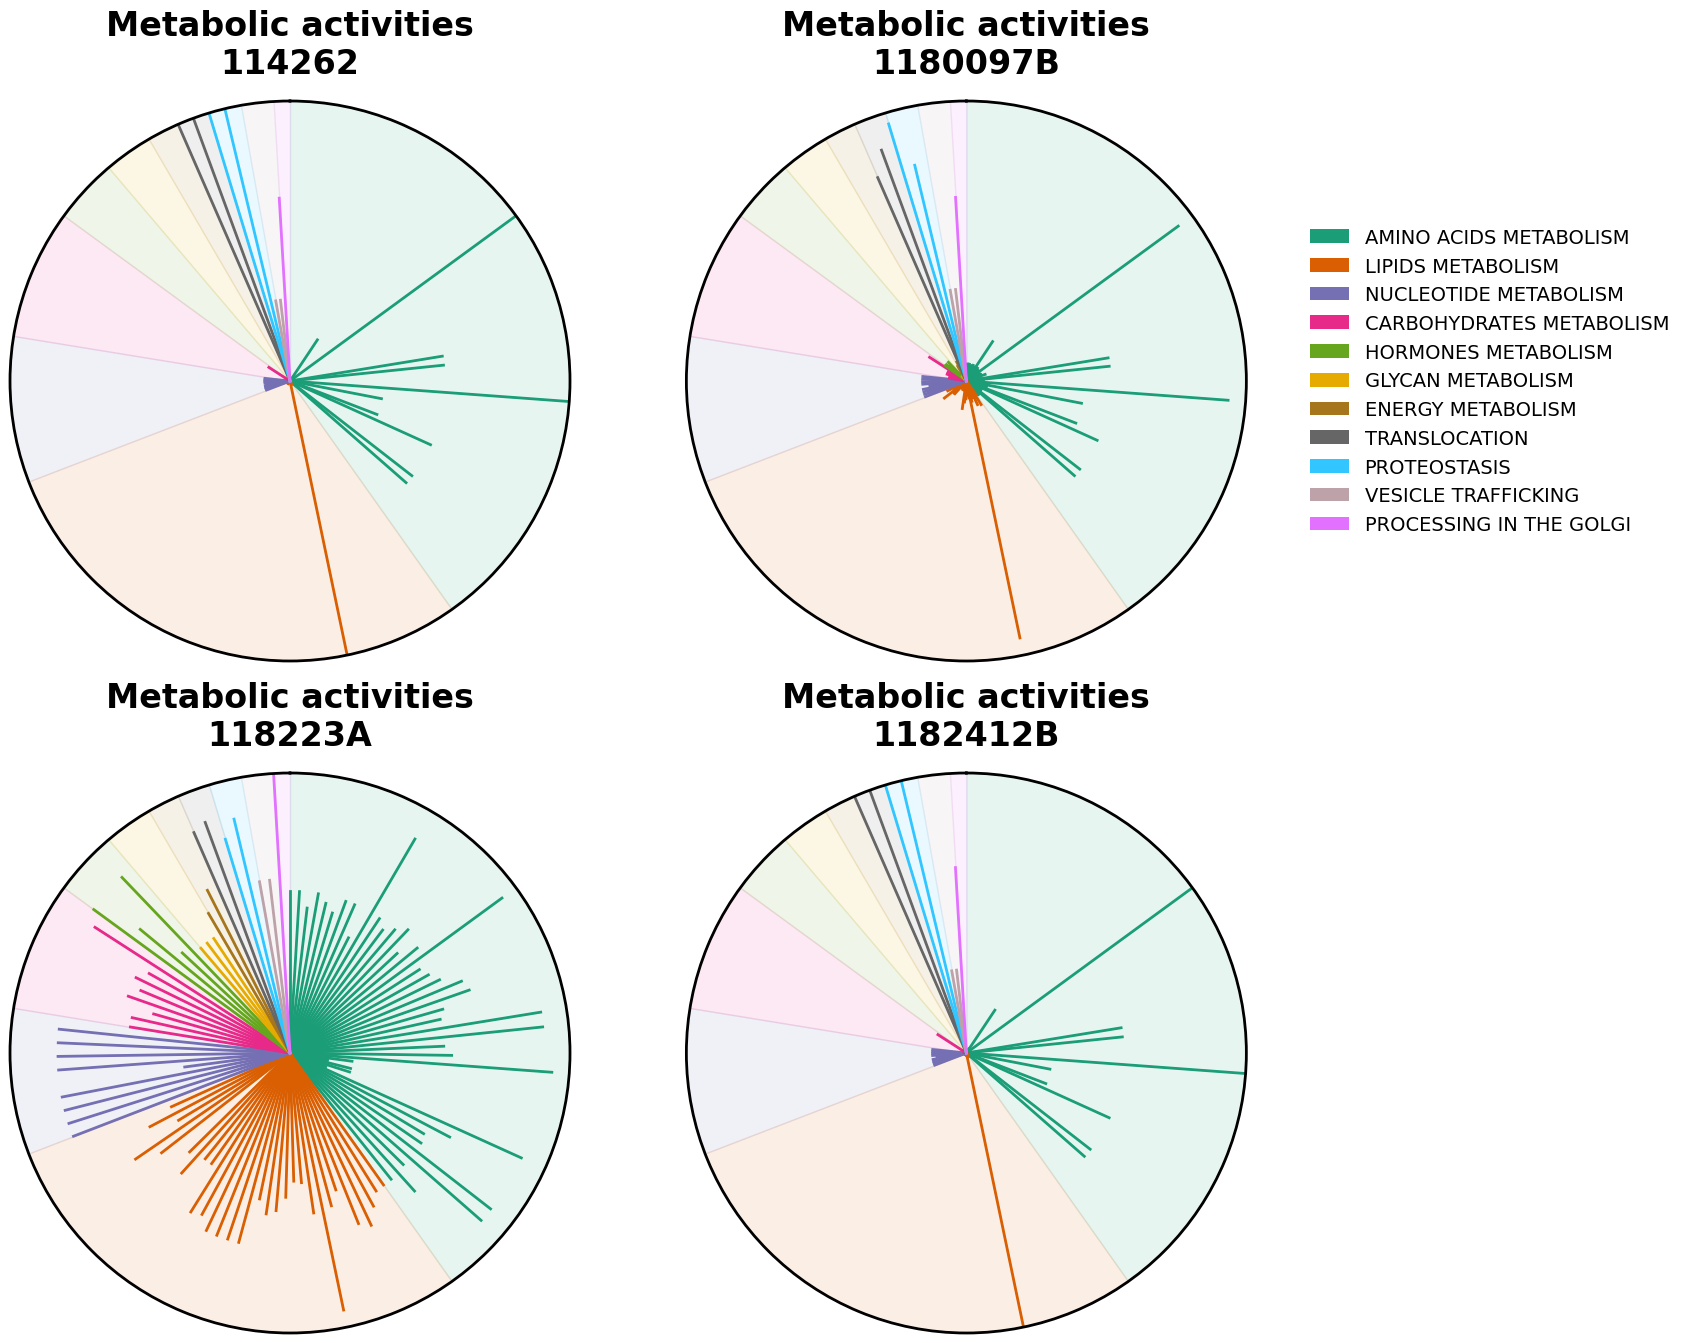

In [61]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221, projection='polar')
ax2 = fig.add_subplot(222, projection='polar')
ax3 = fig.add_subplot(223, projection='polar')
ax4 = fig.add_subplot(224, projection='polar')

for i, (cell, ax) in enumerate(zip(gp, [ax1, ax2, ax3, ax4])):
    sccellfie.plotting.create_radial_plot(df_melted, 
                                          results['task_info'],
                                          cell_type=str(ct[i]),
                                          ax=ax,
                                          show_legend=i == 1,
                                          ylim=1.0)

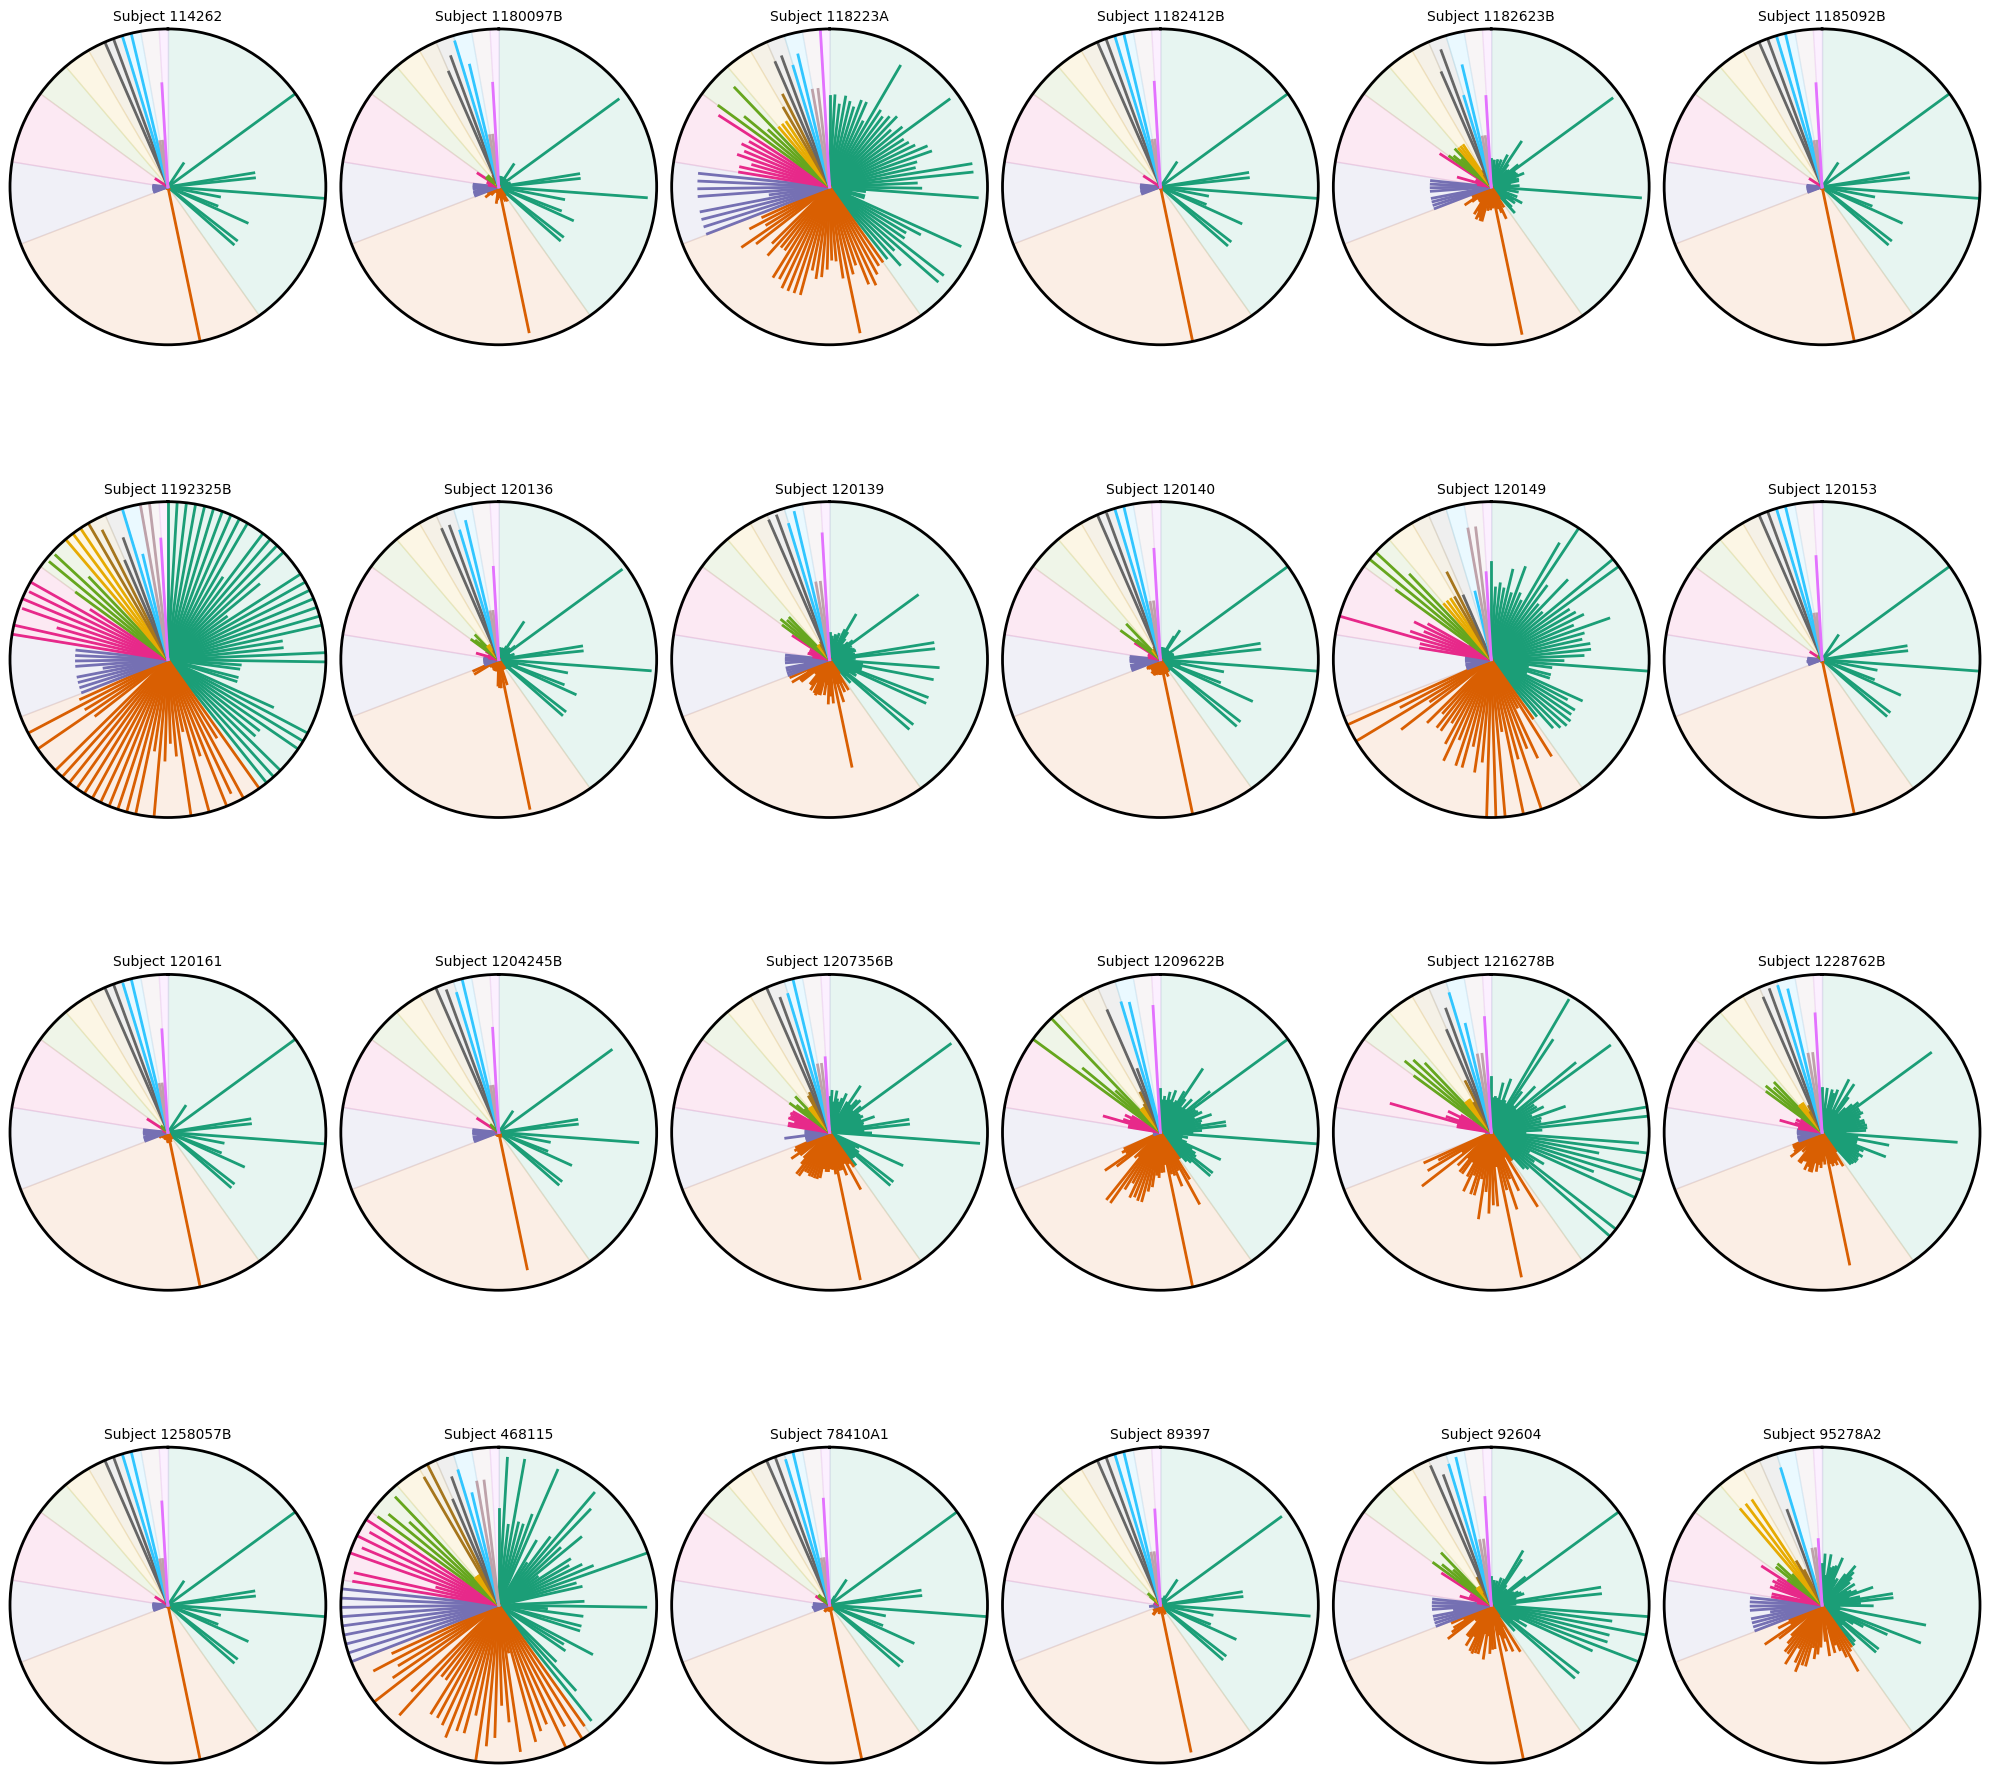

In [ ]:
# Number of subjects
n_subjects = 24

# make a grid: 6x4 works well for 24
n_cols = 6
n_rows = math.ceil(n_subjects / n_cols)

cell_type_data = df_melted.cell_type.unique()

fig, axes = plt.subplots(
    n_rows, n_cols,
    subplot_kw=dict(projection='polar'),
    figsize=(20, 20)
)

# flatten axes for easy indexing
axes = axes.flatten()

for i in range(n_subjects):
    ax = axes[i]
    sccellfie.plotting.create_radial_plot(
        df_melted, 
        results['task_info'],
        cell_type=str(cell_type_data[i]),   
        ax=ax,
        show_legend=False,  
        ylim=1.0
    )
    ax.set_title(f"Subject {cell_type_data[i]}", fontsize=10)

# hide any unused subplots (in case n_subjects doesn’t fill the grid)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout() 
plt.show()
